In [1]:
import numpy as np
import pandas as pd

import random
random.seed(42)
# 导入需要的库

In [3]:
dataset = pd.read_csv('TSLA.csv',encoding='utf8')
dataset # 导入TSLA的股票数据

,Date,Close,Open,High,Low,count,zhangdie
0,2021年7月30日,687.20,671.76,697.53,669.00,29.66M,1.45%
1,2021年7月29日,677.35,649.60,683.47,649.40,30.39M,4.69%
2,2021年7月28日,646.98,647.25,654.91,639.84,16.01M,0.34%
3,2021年7月27日,644.78,663.00,666.31,627.27,32.81M,-1.95%
4,2021年7月26日,657.62,650.24,668.16,647.11,25.34M,2.21%
...,...,...,...,...,...,...,...
353,2020年3月6日,140.70,138.00,141.40,136.85,63.31M,-2.91%
354,2020年3月5日,144.91,144.75,149.15,143.61,54.26M,-3.33%
355,2020年3月4日,149.90,152.79,153.30,144.95,75.24M,0.54%
356,2020年3月3日,149.10,161.00,161.40,143.22,128.92M,0.26%


In [5]:
# 清除掉NAN值
dataset = dataset.dropna()
dataset = dataset[['Open', 'High', 'Low', 'Close']]

In [8]:
# 计算 最高价与最低价之差，开盘价与收盘价之差，3天移动平均线，10天移动平均线，
#     30天移动平均线，5天内平均方差。相对强弱指数，威廉指标
import talib  # 导入talib库  安装需离线下载whl文件进行安装
dataset['H-L'] = dataset['High'] - dataset['Low']
dataset['O-C'] = dataset['Close'] - dataset['Open']
dataset['3day MA'] = dataset['Close'].shift(1).rolling(window = 3).mean()
dataset['10day MA'] = dataset['Close'].shift(1).rolling(window = 10).mean()
dataset['30day MA'] = dataset['Close'].shift(1).rolling(window = 30).mean()
dataset['Std_dev']= dataset['Close'].rolling(5).std()
dataset['RSI'] = talib.RSI(dataset['Close'].values, timeperiod = 9)
dataset['Williams %R'] = talib.WILLR(dataset['High'].values, dataset['Low'].values, dataset['Close'].values, 7)

In [9]:
#  股票是否上涨
dataset['Price_Rise'] = np.where(dataset['Close'].shift(-1) > dataset['Close'], 1, 0)

In [10]:
# 用 dropna() 函数丢弃所有包含 NaN 值的行
dataset = dataset.dropna()

In [12]:
# 创建两个数据帧“X”和“y”，存储输入和输出变量。数据帧“X”存储输入特征，
# 它的列从数据集的第 5 列（索引 4）开始一直到倒数第 2 列。
# 最后一列会存储在数据帧“y”中，它是我们想要预测的值，也就是股价涨幅。
X = dataset.iloc[:, 4:-1]
y = dataset.iloc[:, -1]

In [13]:
# 拆分数据集
split = int(len(dataset)*0.8)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [14]:
# 特征缩放
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
# 搭建神经网络  导入需要的库
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [16]:
# 将 Sequential() 函数实例化为变量分类器
classifier = Sequential()

In [17]:
# 利用 add() 函数为分类器添加层，add() 函数的实参（argument）是Dense()函数，它有以下实参：
# Units：它定义了某一层中的节点或神经元的数量。我们这里将值设为 128，也就是说我们的隐藏层中会有 128 个神经元。
# Kernel_initializer：它定义了隐藏层中不同神经元权重的起始值。我们这里将它定义为“uniform”，意味着会用均匀分配的值初始化所有权重。
# Activation：它是隐藏层中神经元的激活函数，这里我们将激活函数定义为修正线性单元函数。
# Input_dim：它定义了输入到隐藏层中的输入数量，我们将输入数量值定义为等于输入特征数据帧中的列的数量。不过在后面的层中不再需要该实参，因为模型知道前一个层中生成的多少输出。
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X.shape[1]))

In [18]:
# 再添加一个层，128 个神经元，具有权重一致的 kernel_initializer，激活函数为修正线性单元。在这个神经网络中我们只搭建两个隐藏层。
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))

In [19]:
# 搭建输出层，只需要一个输出，因此 Units 设为 1，将 S 型函数选为激活函数，因为我们想要预测股市变动的概率。
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [20]:
# 最后传入以下实参来编译分类器：
    # Optimizer：将 optimizer 选为“Adam”，它是随机梯度下降算法的一种扩展形式。
    # Loss：它会定义训练过程中的需要优化的损失，我们将 loss 定义为均方误差。
    # Metrics：它定义模型在训练和测试期间评估的矩阵。我们选择准确率为模型的评估矩阵。
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [21]:
# 将创建的神经网络拟合到训练数据集中，通过向 fit() 函数中传入 X_train，y_train，批量大小和周期数量。
# 批量大小是指模型在反向传播误差和修正权重之前用来计算误差的数据点。周期数是指用训练集训练模型的次数。
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)  # batch_size 和epochs可以调节

Epoch 1/100
27/27 [==============================] - 0s 1ms/step - loss: 0.2442 - accuracy: 0.6985
Epoch 2/100
27/27 [==============================] - 0s 2ms/step - loss: 0.2067 - accuracy: 0.7405
Epoch 3/100
27/27 [==============================] - 0s 2ms/step - loss: 0.1545 - accuracy: 0.8130
Epoch 4/100
27/27 [==============================] - 0s 3ms/step - loss: 0.1387 - accuracy: 0.8168
Epoch 5/100
27/27 [==============================] - 0s 3ms/step - loss: 0.1329 - accuracy: 0.8244
Epoch 6/100
27/27 [==============================] - 0s 3ms/step - loss: 0.1336 - accuracy: 0.8168
Epoch 7/100
27/27 [==============================] - 0s 3ms/step - loss: 0.1290 - accuracy: 0.8321
Epoch 8/100
27/27 [==============================] - 0s 2ms/step - loss: 0.1331 - accuracy: 0.8168
Epoch 9/100
27/27 [==============================] - 0s 2ms/step - loss: 0.1317 - accuracy: 0.8397
Epoch 10/100
27/27 [==============================] - 0s 2ms/step - loss: 0.1275 - accuracy: 0.8511
Epoch 11/

In [22]:
# 预测股票动向
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

In [37]:
# 使用 predict() 函数做出预测。将 X_test 作为实参传入模型，将结果保存为一个变量，名为 y_pred。
# 然后我们在 y_pred > 5 条件下将 y_pred 进行转换，保存二进制值。现在变量 y_pred 会根据预测值是否大于 0.5 保存为 Ture 或 False。
dataset['y_pred'] = np.NaN
dataset.iloc[(len(dataset) - len(y_pred)):,-1:] = y_pred
trade_dataset = dataset.dropna()

In [38]:
# 市场收益
# 创建一个新列命名为“Tomorrows Returns”，保存为值0。我们用十进法表示保存在新列中的浮点值。
# 接下来，我们将其保存为当天的对数收益率，即昨天收盘价除以当天收盘价的对数。
# 然后我们将这些值上移一个元素，这样第二天的收益会按照当天的股价进行保存。
trade_dataset['Tomorrows Returns'] = 0.
trade_dataset['Tomorrows Returns'] = np.log(trade_dataset['Close']/trade_dataset['Close'].shift(1))
trade_dataset['Tomorrows Returns'] = trade_dataset['Tomorrows Returns'].shift(-1)

<ipython-input-38-0cc4737001f8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_dataset['Tomorrows Returns'] = 0.
<ipython-input-38-0cc4737001f8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_dataset['Tomorrows Returns'] = np.log(trade_dataset['Close']/trade_dataset['Close'].shift(1))
<ipython-input-38-0cc4737001f8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [50]:
# 模型收益
# 创建一个新列，标题为“Strategy_Returns”，以0.（表示存储浮点值）初始化它。
# 使用 np.where() 函数，接着如果“y_pred”列为 True（多头交易），我们会将值保存在列“Tomorrow Returns”中，
# 否则将在列“Tomorrow Returns”（空头交易）中的值的负值保存到列“Strategy_Returns”中。

trade_dataset['Strategy Returns'] = 0.
trade_dataset['Strategy Returns'] = np.where(trade_dataset['y_pred'] == True, trade_dataset['Tomorrows Returns'], - trade_dataset['Tomorrows Returns'])

<ipython-input-50-77660cc85d4a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_dataset['Strategy Returns'] = 0.
<ipython-input-50-77660cc85d4a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_dataset['Strategy Returns'] = np.where(trade_dataset['y_pred'] == True, trade_dataset['Tomorrows Returns'], - trade_dataset['Tomorrows Returns'])


In [51]:
# 计算市场和模型的累计收益。使用 cumsum() 函数计算这些值。
trade_dataset['Cumulative Market Returns'] = np.cumsum(abs(trade_dataset['Tomorrows Returns']))
trade_dataset['Cumulative Strategy Returns'] = np.cumsum(trade_dataset['Strategy Returns'])

<ipython-input-51-912318ade53e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_dataset['Cumulative Market Returns'] = np.cumsum(abs(trade_dataset['Tomorrows Returns']))
<ipython-input-51-912318ade53e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_dataset['Cumulative Strategy Returns'] = np.cumsum(trade_dataset['Strategy Returns'])


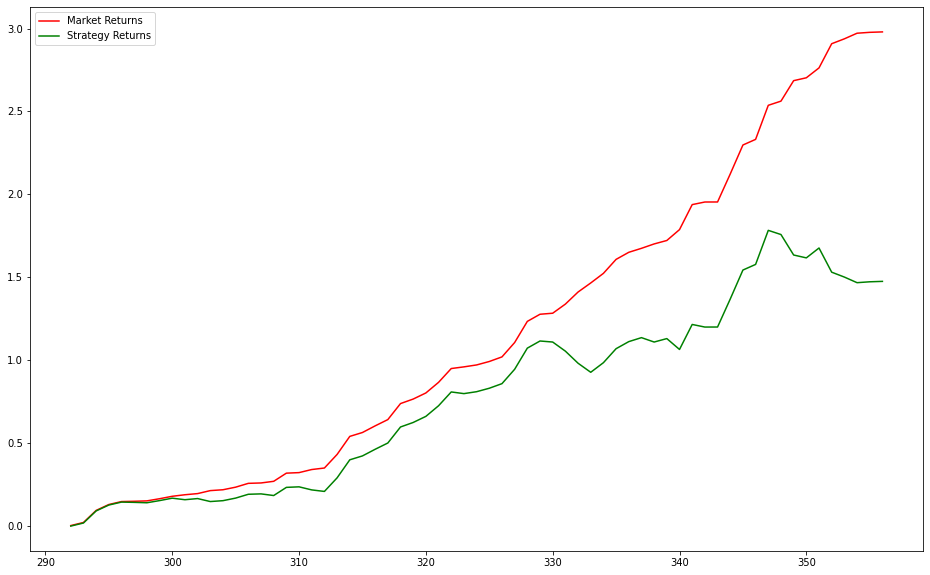

In [52]:
# 用累计的和来绘制出上一步中市场收益和模型收益的走势图。
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
plt.plot(trade_dataset['Cumulative Market Returns'], color='r', label='Market Returns')
plt.plot(trade_dataset['Cumulative Strategy Returns'], color='g', label='Strategy Returns')
plt.legend()
plt.show()

In [54]:
trade_dataset.to_csv('trade_dataset.csv',index=False)